# Kaggle competition: ASHRAE - Great Energy Predictor III : The goal of this competition was to predict the energy consumption of different buildings in different sites.
## Link to the competition: https://www.kaggle.com/c/ashrae-energy-prediction/overview

## First we import the libraries that we will need

In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from math import sqrt
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer

## This function will allow to reduce the memory usage of our dataframes

In [2]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype#.name
        
        if col_type != object and col_type.name != 'category' :
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                
                ## FLOAT 16 DOESNT WORK WELL ='(
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Now let's import the data and analyze it 

In [3]:
data_building=pd.read_csv("building_metadata.csv ")
print(data_building.head())
print(data_building.describe())
data_building=reduce_mem_usage(data_building)
print(data_building.info())

   site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN
           site_id  building_id    square_feet   year_built  floor_count
count  1449.000000  1449.000000    1449.000000   675.000000   355.000000
mean      6.952381   724.000000   92111.776398  1967.957037     3.740845
std       5.003432   418.434583  110769.950997    31.054030     3.333683
min       0.000000     0.000000     283.000000  1900.000000     1.000000
25%       3.000000   362.000000   23012.000000  1949.000000     1.000000
50%       5.000000   724.000000   57673.000000  1970.000000     3.000000
75%      13.000000  1086.000000  115676.00000

## It seems that we have some outliers in meter reading

In [4]:
data_train=pd.read_csv("train.csv")
print(data_train.head())
print(data_train.describe())
data_train=reduce_mem_usage(data_train)
print(data_train.info())

   building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            1      0  2016-01-01 00:00:00            0.0
2            2      0  2016-01-01 00:00:00            0.0
3            3      0  2016-01-01 00:00:00            0.0
4            4      0  2016-01-01 00:00:00            0.0
        building_id         meter  meter_reading
count  2.021610e+07  2.021610e+07   2.021610e+07
mean   7.992780e+02  6.624412e-01   2.117121e+03
std    4.269133e+02  9.309921e-01   1.532356e+05
min    0.000000e+00  0.000000e+00   0.000000e+00
25%    3.930000e+02  0.000000e+00   1.830000e+01
50%    8.950000e+02  0.000000e+00   7.877500e+01
75%    1.179000e+03  1.000000e+00   2.679840e+02
max    1.448000e+03  3.000000e+00   2.190470e+07
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 col

## We have too much missing data in the columns cloud_coverage  and precip_depth_1_hr, we will need to remove them

In [5]:
data_weather=pd.read_csv("weather_train.csv")
print(data_weather.head())
print(data_weather.describe())
data_weather=reduce_mem_usage(data_weather)
print(data_weather.info())

   site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2016-01-01 00:00:00             25.0             6.0   
1        0  2016-01-01 01:00:00             24.4             NaN   
2        0  2016-01-01 02:00:00             22.8             2.0   
3        0  2016-01-01 03:00:00             21.1             2.0   
4        0  2016-01-01 04:00:00             20.0             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.7             0.0   
1             21.1               -1.0              1020.2            70.0   
2             21.1                0.0              1020.2             0.0   
3             20.6                0.0              1020.1             0.0   
4             20.0               -1.0              1020.0           250.0   

   wind_speed  
0         0.0  
1         1.5  
2         0.0  
3         0.0  
4         2.6  
             site_id  air_temper

In [6]:
test=pd.read_csv("test.csv")
test=reduce_mem_usage(test)
print(test.head())
submission=pd.read_csv("sample_submission.csv")
submission=reduce_mem_usage(submission)

print(submission.head())

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%
   row_id  building_id  meter            timestamp
0       0            0      0  2017-01-01 00:00:00
1       1            1      0  2017-01-01 00:00:00
2       2            2      0  2017-01-01 00:00:00
3       3            3      0  2017-01-01 00:00:00
4       4            4      0  2017-01-01 00:00:00
Memory usage of dataframe is 636.25 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%
   row_id  meter_reading
0       0              0
1       1              0
2       2              0
3       3              0
4       4              0


In [7]:
weather_test=pd.read_csv("weather_test.csv")
print(weather_test.head())
print(weather_test.describe())
weather_test=reduce_mem_usage(weather_test)
print(weather_test.info())

   site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2017-01-01 00:00:00             17.8             4.0   
1        0  2017-01-01 01:00:00             17.8             2.0   
2        0  2017-01-01 02:00:00             16.1             0.0   
3        0  2017-01-01 03:00:00             17.2             0.0   
4        0  2017-01-01 04:00:00             16.7             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             11.7                NaN              1021.4           100.0   
1             12.8                0.0              1022.0           130.0   
2             12.8                0.0              1021.9           140.0   
3             13.3                0.0              1022.2           140.0   
4             13.3                0.0              1022.3           130.0   

   wind_speed  
0         3.6  
1         3.1  
2         3.1  
3         3.1  
4         2.6  
             site_id  air_temper

## Let's remove columns with many missing values and fill the rest with the mean

In [8]:
def replaceNan(df):
    categorical_feature_mask = df.dtypes !='category'
    categorical_cols = df.columns[categorical_feature_mask].tolist()
    df[categorical_cols]=df[categorical_cols].fillna(df[categorical_cols].mean().round(1))
    return df

data_building.drop(columns=["year_built","floor_count"],inplace=True)
data_weather.drop(columns=["cloud_coverage","precip_depth_1_hr"],inplace=True)
weather_test.drop(columns=["cloud_coverage","precip_depth_1_hr"],inplace=True)

weather_test=replaceNan(weather_test)
data_building=replaceNan(data_building)
data_weather=replaceNan(data_weather)


In [9]:
data_train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


## Merge the dataframes together

In [10]:
merged_data=data_train.merge(data_building,on=["building_id"])
merged_data=merged_data.merge(data_weather,on=['site_id','timestamp'],how='left')
merged_data=reduce_mem_usage(merged_data)
merged_data.head()

Memory usage of dataframe is 829.40 MB
Memory usage after optimization is: 829.40 MB
Decreased by 0.0%


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,25.000000,20.0,1019.700012,0.0,0.0
1,0,0,2016-01-01 01:00:00,0.0,0,Education,7432,24.400000,21.1,1020.200012,70.0,1.5
2,0,0,2016-01-01 02:00:00,0.0,0,Education,7432,22.799999,21.1,1020.200012,0.0,0.0
3,0,0,2016-01-01 03:00:00,0.0,0,Education,7432,21.100000,20.6,1020.099976,0.0,0.0
4,0,0,2016-01-01 04:00:00,0.0,0,Education,7432,20.000000,20.0,1020.000000,250.0,2.6


## Let's now convert timestamps 

In [11]:
def extract_time(merged_data):    
    merged_data["day"]=pd.to_datetime(merged_data["timestamp"]).dt.day
    merged_data["week"]=pd.to_datetime(merged_data["timestamp"]).dt.week
    merged_data["month"]=pd.to_datetime(merged_data["timestamp"]).dt.month
    merged_data["hour"]=pd.to_datetime(merged_data["timestamp"]).dt.hour
    merged_data["year"]=pd.to_datetime(merged_data["timestamp"]).dt.year
    merged_data.sort_values(by=["timestamp"],inplace=True)
    #merged_data.drop(columns="timestamp",inplace=True)
    return merged_data


merged_data=extract_time(merged_data)

## Label encoding primary_use column

In [12]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(merged_data[["primary_use"]])
merged_data["primary_use"]=ordinal_encoder.transform(merged_data[["primary_use"]])
merged_data=reduce_mem_usage(merged_data)

Memory usage of dataframe is 1735.54 MB
Memory usage after optimization is: 1002.92 MB
Decreased by 42.2%


## Adding columns to test set

In [13]:
test.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [14]:
merged_test=test.merge(data_building,on="building_id")
merged_test=merged_test.merge(weather_test,on=['site_id','timestamp'],how="left")

merged_test["primary_use"]=ordinal_encoder.transform(merged_test[["primary_use"]])
merged_test=extract_time(merged_test)

merged_test=reduce_mem_usage(merged_test)


Memory usage of dataframe is 3579.69 MB
Memory usage after optimization is: 2068.59 MB
Decreased by 42.2%


## Handling outliers in train set ( Should've done it in the beggining)

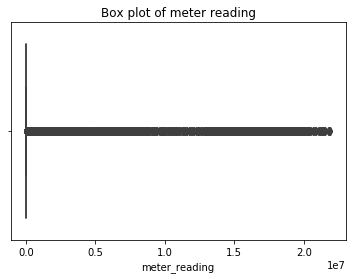

In [137]:
sns.boxplot(x=merged_data["meter_reading"]).set_title("Box plot of meter reading");

In [15]:
merged_data["log_meter_reading"]=np.log1p(merged_data.meter_reading)
merged_data=reduce_mem_usage(merged_data)


Memory usage of dataframe is 1080.04 MB
Memory usage after optimization is: 1080.04 MB
Decreased by 0.0%


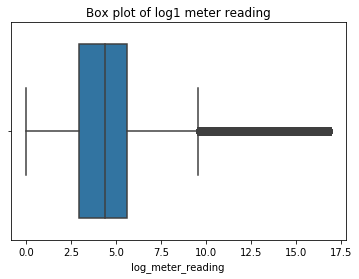

In [15]:
sns.boxplot(x=merged_data["log_meter_reading"]).set_title("Box plot of log1 meter reading");

## Now let's analyse the distribution of buildings and primary uses in train and test;        we can see that we have the same distribution, and we have to keep this distribution in the validation set

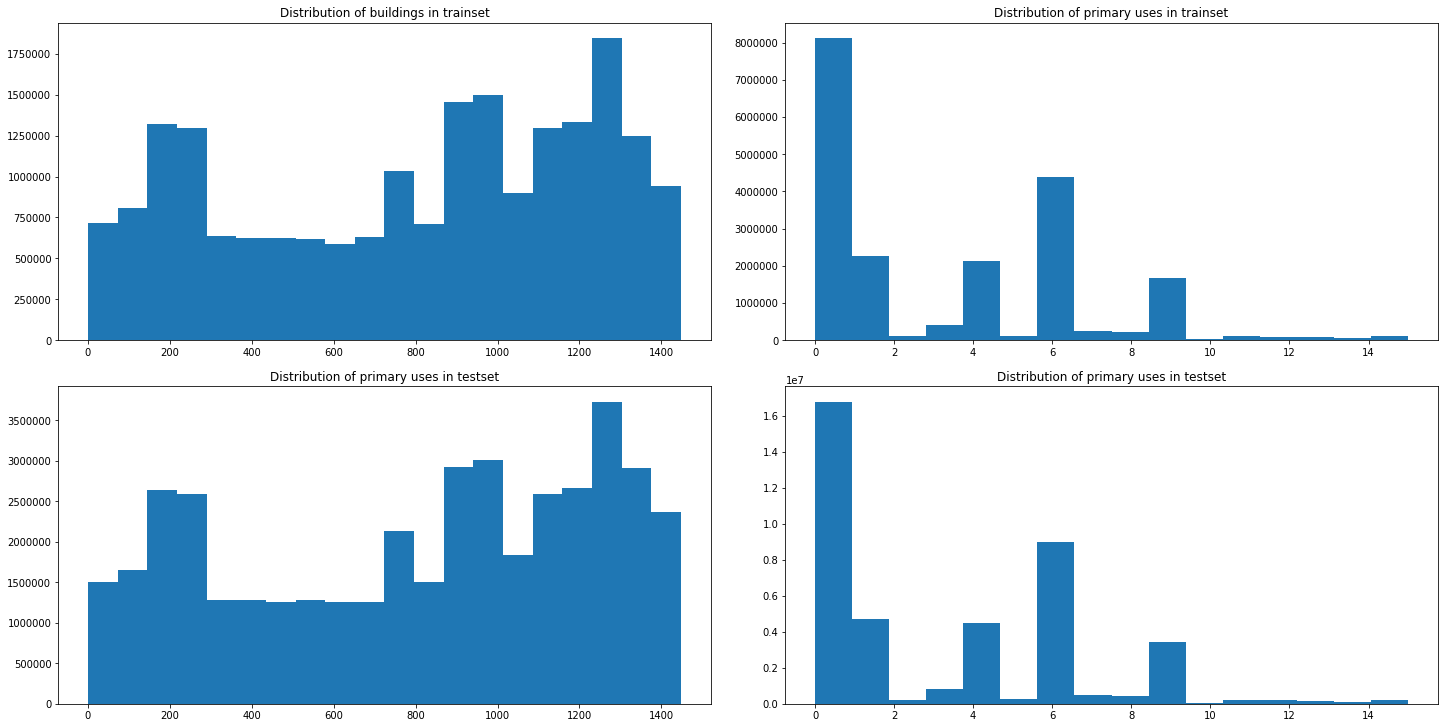

In [14]:
fig, axs = plt.subplots(2, 2, constrained_layout=True,figsize=(20, 10))
#fig, ax = plt.subplots(figsize=(20, 10))
# merged_data.building_id.hist(ax=ax,bins=20) 
# merged_data.primary_use.hist()

axs[0,0].hist(merged_data.building_id,bins=20);
axs[0,0].set_title('Distribution of buildings in trainset');

axs[0,1].hist(merged_data.primary_use,bins=16);
axs[0,1].set_title('Distribution of primary uses in trainset');

axs[1,0].hist(merged_test2.building_id,bins=20);
axs[1,0].set_title('Distribution of primary uses in testset');

axs[1,1].hist(merged_test2.primary_use,bins=16);
axs[1,1].set_title('Distribution of primary uses in testset');
#axs[1,0].hist(test.primary_use,bins=16)

In [19]:
X=merged_data.drop(columns=["meter_reading","timestamp","log_meter_reading"])
X=reduce_mem_usage(X)
y=merged_data["log_meter_reading"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=False)

Memory usage of dataframe is 886.86 MB
Memory usage after optimization is: 886.86 MB
Decreased by 0.0%


## Here we check the distribution of the data in the validation set, it is very similar to that of the train and test sets

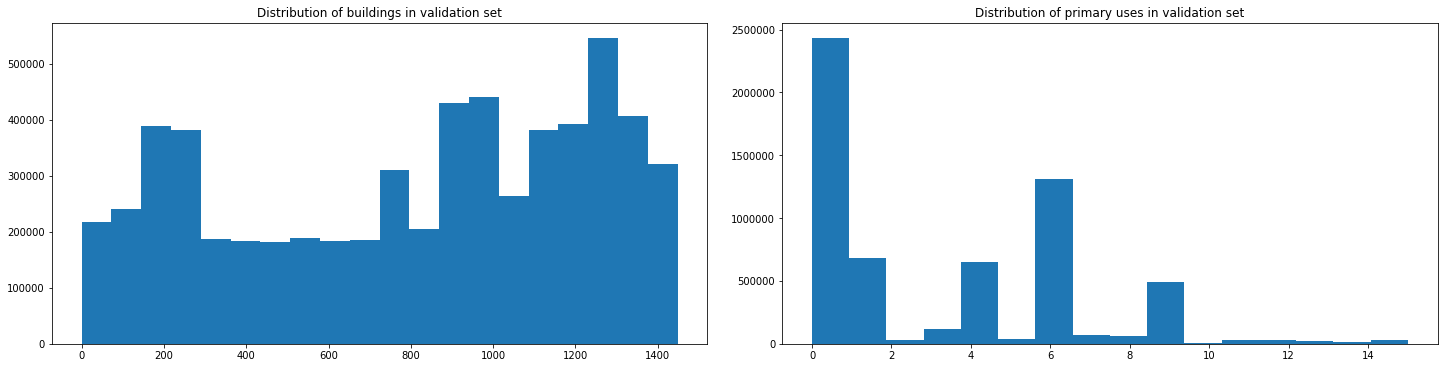

In [112]:
fig, axs = plt.subplots(1, 2, constrained_layout=True,figsize=(20, 5))
axs[0].hist(X_test.building_id,bins=20);
axs[0].set_title('Distribution of buildings in validation set');

axs[1].hist(X_test.primary_use,bins=16);
axs[1].set_title('Distribution of primary uses in validation set');
#X_test.building_id.hist(bins=20)

## Train the model before adding addtionnal features

In [20]:
model = LGBMRegressor(max_depth=3,n_estimators=100)
model.fit(X_train, y_train);
print("made it here")
y_pred=model.predict(X_test)
y_pred=np.expm1(y_pred)
y_test=np.expm1(y_test)
error=np.sqrt(mean_squared_log_error( y_test, y_predy ))
print(error)


made it here
1.6563581265876683


## Perfect, now let's do some feature engineering to improve the score

In [16]:
def convert_season(month):
    if (month <= 2) | (month == 12):
        return 0
    elif month <= 5:
        return 1
    elif month <= 8:
        return 2
    elif month <= 11:
        return 3


def convert_windDirection(wind_direction):
    if wind_direction <= 90:
        return 0
    elif wind_direction <= 180:
        return 1
    elif wind_direction <= 270:
        return 2
    elif wind_direction <= 360:
        return 3

    


In [17]:
merged_data['weekend'] = merged_data.day.apply(lambda x: 1 if x>=5 else 0)
merged_data["season"]=merged_data["month"].apply(convert_season)
merged_data["wind_direction_Converted"]=merged_data["wind_direction"].apply(convert_windDirection)


#merged_data['temperature_categories']=pd.cut(merged_data.air_temperature,bins=20,labels=list(range(0,20)))

merged_test['weekend'] = merged_test.day.apply(lambda x: 1 if x>=5 else 0)
merged_test["season"]=merged_test["month"].apply(convert_season)
merged_test["wind_direction_Converted"]=merged_test["wind_direction"].apply(convert_windDirection)

merged_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,...,wind_speed,day,week,month,hour,year,log_meter_reading,weekend,season,wind_direction_Converted
0,0,0,2016-01-01 00:00:00,0.000000,0,0.0,7432,25.0,20.0,1019.700012,...,0.0,1,53,1,0,2016,0.000000,0,0,0.0
14192155,1137,1,2016-01-01 00:00:00,0.000000,13,6.0,27452,-8.3,-12.2,1023.299988,...,4.1,1,53,1,0,2016,0.000000,0,0,2.0
14192154,1137,0,2016-01-01 00:00:00,9.000000,13,6.0,27452,-8.3,-12.2,1023.299988,...,4.1,1,53,1,0,2016,2.302585,0,0,2.0
14174587,1136,1,2016-01-01 00:00:00,3.498600,13,6.0,79782,-8.3,-12.2,1023.299988,...,4.1,1,53,1,0,2016,1.503766,0,0,2.0
14174586,1136,0,2016-01-01 00:00:00,39.519001,13,6.0,79782,-8.3,-12.2,1023.299988,...,4.1,1,53,1,0,2016,3.701771,0,0,2.0


## These lines will allow us to avoid rerunning the code from the beggining if the notebook shutsdown

In [18]:
merged_data.to_pickle("./merged_data.pkl")
merged_test.to_pickle("./merged_test.pkl")

In [2]:
merged_test = pd.read_pickle("./merged_test.pkl")
merged_data = pd.read_pickle("./merged_data.pkl")


## We are going to add features that depend on the target, so let's divide our data into training and validation 

In [19]:
percent=int(0.2*len(merged_data))
trainset=merged_data[:-percent]
validationset=merged_data[-percent:]

In [20]:
grouped_consumption=trainset.groupby(['building_id','meter'])['log_meter_reading'].agg([
    ("meter_reading_mean",'mean'),("meter_reading_median",'median')]).reset_index()

grouped_consumption_per_hour_per_season=trainset.groupby(['building_id','meter','hour','season'])['log_meter_reading'].agg([
    ("meter_reading_mean_hourSeason",'mean'),("meter_reading_median_hourSeason",'median')]).reset_index()
grouped_consumption.head()

,building_id,meter,meter_reading_mean,meter_reading_median
0,0,0,2.896107,5.218240
1,1,0,2.613936,4.611687
2,2,0,1.685359,1.966133
3,3,0,3.101951,4.986240
4,4,0,3.874557,7.288507


In [12]:
trainset=trainset.merge(grouped_consumption,on=['building_id','meter'])
trainset=trainset.merge(grouped_consumption_per_hour_per_season,on=['building_id','meter','hour','season'])

validationset=validationset.merge(grouped_consumption,on=['building_id','meter'])
validationset=validationset.merge(grouped_consumption_per_hour_per_season,on=['building_id','meter','hour','season'])

merged_test=merged_test.merge(grouped_consumption,on=['building_id','meter'])
merged_test=merged_test.merge(grouped_consumption_per_hour_per_season,on=['building_id','meter','hour','season'])


In [22]:
X_train=trainset.drop(columns=["meter_reading","timestamp","log_meter_reading"])
X_test=validationset.drop(columns=["meter_reading","timestamp","log_meter_reading"])

#X_train=reduce_mem_usage(X_train)
y_train=trainset["log_meter_reading"]
y_test=validationset["log_meter_reading"]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=False)

In [23]:
model = LGBMRegressor(max_depth=3,n_estimators=100)
model.fit(X_train, y_train);
print("made it here")
y_pred=model.predict(X_test)
y_pred=np.clip(np.expm1(y_pred),0,max(np.expm1(y_pred)))
y_test=np.expm1(y_test)
error=np.sqrt(mean_squared_log_error( y_test, y_pred ))
print(error)

made it here
1.4345873762044525


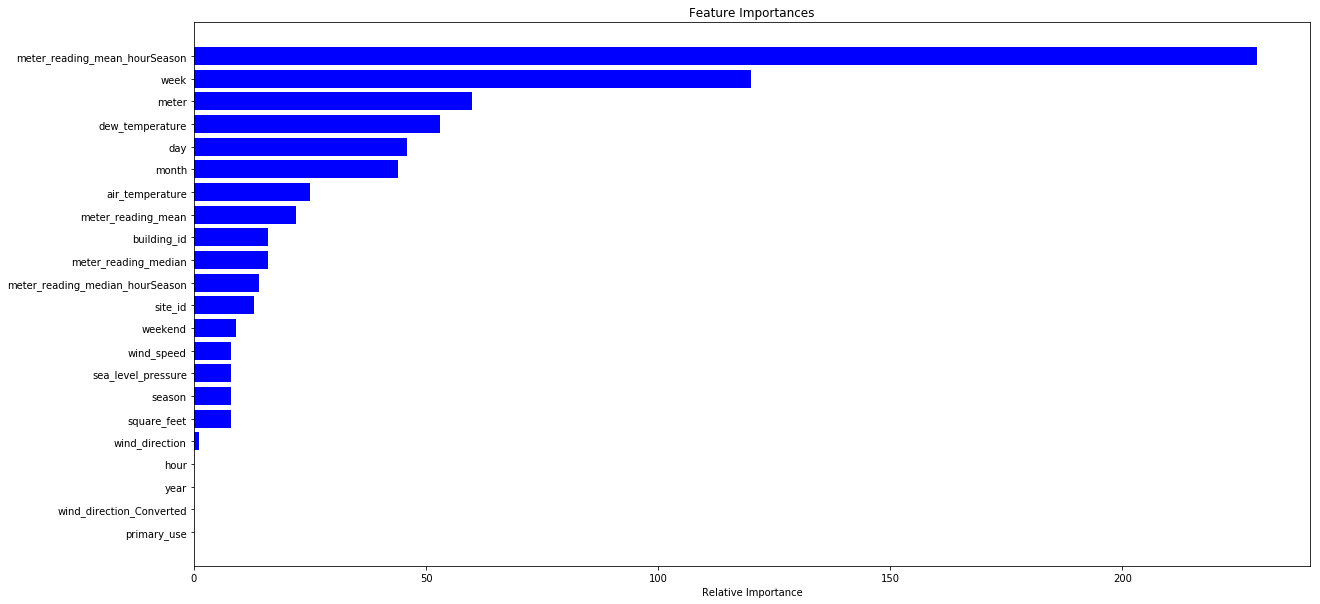

In [24]:
importances=model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')


plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


## Now for the submission let's fit the model on the whole data set

In [5]:
grouped_consumption_full=merged_data.groupby(['building_id','meter'])['log_meter_reading'].agg([
    ("meter_reading_mean",'mean'),("meter_reading_median",'median')]).reset_index()

grouped_consumption_per_hour_per_season_full=merged_data.groupby(['building_id','meter','hour','season'])['log_meter_reading'].agg([
    ("meter_reading_mean_hourSeason",'mean'),("meter_reading_median_hourSeason",'median')]).reset_index()


merged_data_full=merged_data.merge(grouped_consumption_full,on=['building_id','meter'])
merged_data_full=merged_data_full.merge(grouped_consumption_per_hour_per_season_full,on=['building_id','meter','hour','season'])

merged_test=merged_test.merge(grouped_consumption_full,on=['building_id','meter'],how='left')
merged_test=merged_test.merge(grouped_consumption_per_hour_per_season_full,on=['building_id','meter','hour','season'],how='left')



In [6]:
X=merged_data_full.drop(columns=["meter_reading","timestamp","log_meter_reading"])
y=merged_data_full["log_meter_reading"]
model = LGBMRegressor(max_depth=3,n_estimators=100)
model.fit(X, y);

In [7]:
y_predict_submit=model.predict(merged_test[X.columns])
y_predict_submit=np.clip(np.expm1(y_predict_submit),0,max(np.expm1(y_predict_submit)))

## Here we submit the predicted values so that it can be avaluated on the leaderboard of kaggle

In [8]:
submission_df=merged_test[['row_id']]
submission_df["meter_reading"]=y_predict_submit
submission=submission_df[["row_id","meter_reading"]]
submission.head()

C:\Users\Ghassen Cherni\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,row_id,meter_reading
0,0,3.078746
1,41613054,140.513462
2,41613055,170.099657
3,41613056,756.449973
4,41613057,32.450019


In [9]:
submission.to_csv('submission.csv', index=False)